# Custom Alpha Factor Analysis - Volatility Adjusted Momentum
----------------
#### FOR EDUCATIONAL USE ONLY. PLEASE SEE DISCLOSURE IN ROOT DIRECTORY OF REPOSITORY.
----------------

This notebook will demonstrate the use of Quantopian's Pipeline API and Alphalens library to analyze a user-created custom momentum factor.

## 1) Import all necessary modules

In [7]:
# Typical imports for use with Pipeline
from quantopian.pipeline import Pipeline, CustomFactor
from quantopian.research import run_pipeline

# Datasets needed to compute factors
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.data import morningstar

# Factors, Classifiers, and Filters
from quantopian.pipeline.factors import Returns
from quantopian.pipeline.classifiers.morningstar import Sector
from quantopian.pipeline.filters.morningstar import Q500US, Q1500US

import alphalens as al
import pandas as pd
import numpy as np

In [8]:
def run_pipe_in_chunks(pipe, start_date, end_date, 
                       weeks = 25, days = 0):
    """Run pipeline in chunks to avoid memory overload
    --------
    Inputs:
    --------
    pipe: pipeline object
    start_date: string, Timestamp, or datetime object
        a date string or datetime object representing the start of the period
    end_date: string, Timestamp, or datetime object
        a date string or datetime object representing the end of the period
    weeks, days: int
        number of weeks and/or days in each chunk
    
    -------
    Return
    --------
    a multi-index dataframe:
         Index=(Date, asset)
         Columns = pipeline columns
    """
    import datetime as dt
    
    # Convert start and end_date to timestamp
    start_date = pd.Timestamp(start_date)
    end_date = pd.Timestamp(end_date)
    
    # Set inital chunk date endpoints
    start = start_date
    step = pd.Timedelta(weeks = weeks, days = days)
    end = start + step
    
    # Initialize a list named chunks to store the pipeline results
    chunks  = []
    while start < end_date:
        # Run pipeline and append to chunks
        print "Running Pipeline for %s to %s" % (start, end)
        result = run_pipeline(pipe, start_date= start, end_date= end)
        chunks.append(result)
        
        # Update start and end dates
        end = result.index.get_level_values(0)[-1].tz_localize(None)
        start = end + pd.Timedelta(days = 1)
        end = start + step
        
        # If end is after last day of period, set to last day of period
        if end > end_date:
            end = end_date
    
    try:
        final_result = pd.concat(chunks, axis = 0)
        print "Pipeline Computations Complete"
    except:
        print 'Concat Failed: Returned List of Dataframes instead of one Dataframe'
        final_result = chunks
        
    return final_result

## Define the Factor

We will create a volatility adjusted 1-year momentum factor that is lagged by 1 month. 

In [10]:
class CustomMomoFactor(CustomFactor):
    """Custom Volatility Adjusted Momentum Factor
    ----------------
    Class Arguments
    ----------------
    window_length: int
        set window_length to (momentum_window + LAG + 1)
    """
    LAG = 21
    
    # Default inputs and window_length
    inputs = [USEquityPricing.close]
    window_length = 274
  
    def compute(self, today, asset_ids, out, close):
        daily_returns = close[1:] / close[:-1] - 1
        std = np.nanstd(daily_returns[:(self.window_length-self.LAG-1)], ddof=1, axis=0)
        out[:] = (close[-self.LAG-1] / close[0] - 1) / std

In [22]:
def make_pipeline():
    """Create a pipeline instance in Quantopian"""
    # Base Universe
    base_universe = Q1500US()
    
    # Additional Filter Example
    # Higher Earnings Filter
#     eps_growth=  morningstar.earnings_ratios.diluted_cont_eps_growth.latest
#     pos_eps_growth = eps_growth > .15
    
    # Combine Filters
    universe = base_universe # & pos_eps_growth
    
    # Momentum Factors
    momo_7_1 = CustomMomoFactor(window_length=148, mask=universe)
    momo_7_1_rank = momo_7_1.rank(method='average', ascending=True, mask=universe)
    
    momo_13_1 = CustomMomoFactor(mask=universe)
    momo_13_1_rank = momo_13_1.rank(method='average', ascending=True, mask=universe)
    
    return Pipeline(columns={'Momentum_7_1': momo_7_1,
                             'Momentum_7_1_rank': momo_7_1_rank,
                             'Momentum_13_1': momo_13_1,
                             'Momentum_13_1_rank': momo_13_1_rank,
                             'Sector_code': Sector()
                              },
                    screen=universe)

In [23]:
start_date = '2004-01-01' 
end_date = '2012-01-01'

# result = run_pipeline(make_pipeline(), start_date, end_date)

# Run Pipeline in chunks
result = run_pipe_in_chunks(make_pipeline(), 
                            start_date, 
                            end_date, 
                            weeks=50, days=0)
  
  

Running Pipeline for 2004-01-01 00:00:00 to 2004-12-16 00:00:00
Running Pipeline for 2004-12-17 00:00:00 to 2005-12-02 00:00:00
Running Pipeline for 2005-12-03 00:00:00 to 2006-11-18 00:00:00
Running Pipeline for 2006-11-21 00:00:00 to 2007-11-06 00:00:00
Running Pipeline for 2007-11-07 00:00:00 to 2008-10-22 00:00:00
Running Pipeline for 2008-10-23 00:00:00 to 2009-10-08 00:00:00
Running Pipeline for 2009-10-09 00:00:00 to 2010-09-24 00:00:00
Running Pipeline for 2010-09-25 00:00:00 to 2011-09-10 00:00:00
Running Pipeline for 2011-09-13 00:00:00 to 2012-01-01 00:00:00
Pipeline Computations Complete


In [25]:
result.head()

Momentum_13_1  \
2004-01-02 00:00:00+00:00 Equity(2 [ARNC])       17.189232   
                          Equity(24 [AAPL])      17.069914   
                          Equity(60 [ABS])       -3.072522   
                          Equity(62 [ABT])        3.253685   
                          Equity(67 [ADSK])      20.871300   

                                             Momentum_13_1_rank  Momentum_7_1  \
2004-01-02 00:00:00+00:00 Equity(2 [ARNC])                739.0     21.397176   
                          Equity(24 [AAPL])               736.0     10.645665   
                          Equity(60 [ABS])                113.0      0.136732   
                          Equity(62 [ABT])                250.0      2.729336   
                          Equity(67 [ADSK])               865.0     23.992759   

                                             Momentum_7_1_rank  Sector_code  
2004-01-02 00:00:00+00:00 Equity(2 [ARNC])              1166.0          101  
                          Equity(24 [AAPL])              671.0          311  
                          Equity(60 [ABS])               205.0          205  
                          Equity(62 [ABT])               313.0          206  
                          Equity(67 [ADSK])             1247.0          311

In [14]:
MORNINGSTAR_SECTOR_CODES = {
     -1: 'Misc',
    101: 'Basic Materials',
    102: 'Consumer Cyclical',
    103: 'Financial Services',
    104: 'Real Estate',
    205: 'Consumer Defensive',
    206: 'Healthcare',
    207: 'Utilities',
    308: 'Communication Services',
    309: 'Energy',
    310: 'Industrials',
    311: 'Technology' ,    
}

In [26]:
assets = result.index.levels[1].unique()

# Set the number of additional days for which to fetch pricing data
FORWARD_DAYS = 252

# Fetch pricing data
pricing = get_pricing(assets, start_date, 
                      pd.Timestamp(end_date) + pd.Timedelta(days=FORWARD_DAYS),
                      fields="open_price")  

PERIODS=(5,21,65,252)

In [29]:
factor_data_13_1 = al.utils.get_clean_factor_and_forward_returns(factor=result['Momentum_13_1_rank'],
                                                            prices=pricing,
                                                            groupby=result['Sector_code'],
                                                            by_group=False,
                                                            groupby_labels=MORNINGSTAR_SECTOR_CODES,
                                                            quantiles=5,
                                                            periods=PERIODS)

Quantiles Statistics


min     max         mean        std   count    count %
factor_quantile                                                           
1                   1.0   304.0   145.901823  84.096934  537146  20.026680
2                 263.0   600.0   436.287625  84.281180  536086  19.987160
3                 525.0   893.0   726.004479  85.095253  536031  19.985109
4                 788.0  1187.0  1016.048470  86.397996  536086  19.987160
5                1052.0  1491.0  1307.712721  88.442560  536803  20.013892

Returns Analysis


5       21      65       252
Ann. alpha                                    -0.008  -0.006  -0.001    0.012
beta                                          -0.076  -0.122  -0.127   -0.155
Mean Period Wise Return Top Quantile (bps)    -5.965 -26.451 -66.233 -117.761
Mean Period Wise Return Bottom Quantile (bps)  0.020  -2.801 -22.411  -88.784
Mean Period Wise Spread (bps)                 -1.359  -1.293  -0.800   -0.296

Information Analysis


5      21     65     252
IC Mean      0.009  0.000 -0.004  0.014
IC Std.      0.143  0.142  0.140  0.156
t-stat(IC)   2.746  0.145 -1.359  4.052
p-value(IC)  0.006  0.885  0.174  0.000
IC Skew     -0.274 -0.482 -0.629 -1.487
IC Kurtosis  0.221  0.447  0.909  2.195
Ann. IR      0.991  0.052 -0.490  1.462

Turnover Analysis


5     21     65    252
Quantile 1 Mean Turnover   0.120  0.257  0.448  0.820
Quantile 2 Mean Turnover   0.272  0.505  0.689  0.825
Quantile 3 Mean Turnover   0.312  0.554  0.721  0.813
Quantile 4 Mean Turnover   0.277  0.510  0.688  0.818
Quantile 5 Mean Turnover   0.125  0.266  0.475  0.862

5    21     65   252
Mean Factor Rank Autocorrelation  0.972  0.89  0.687 -0.05

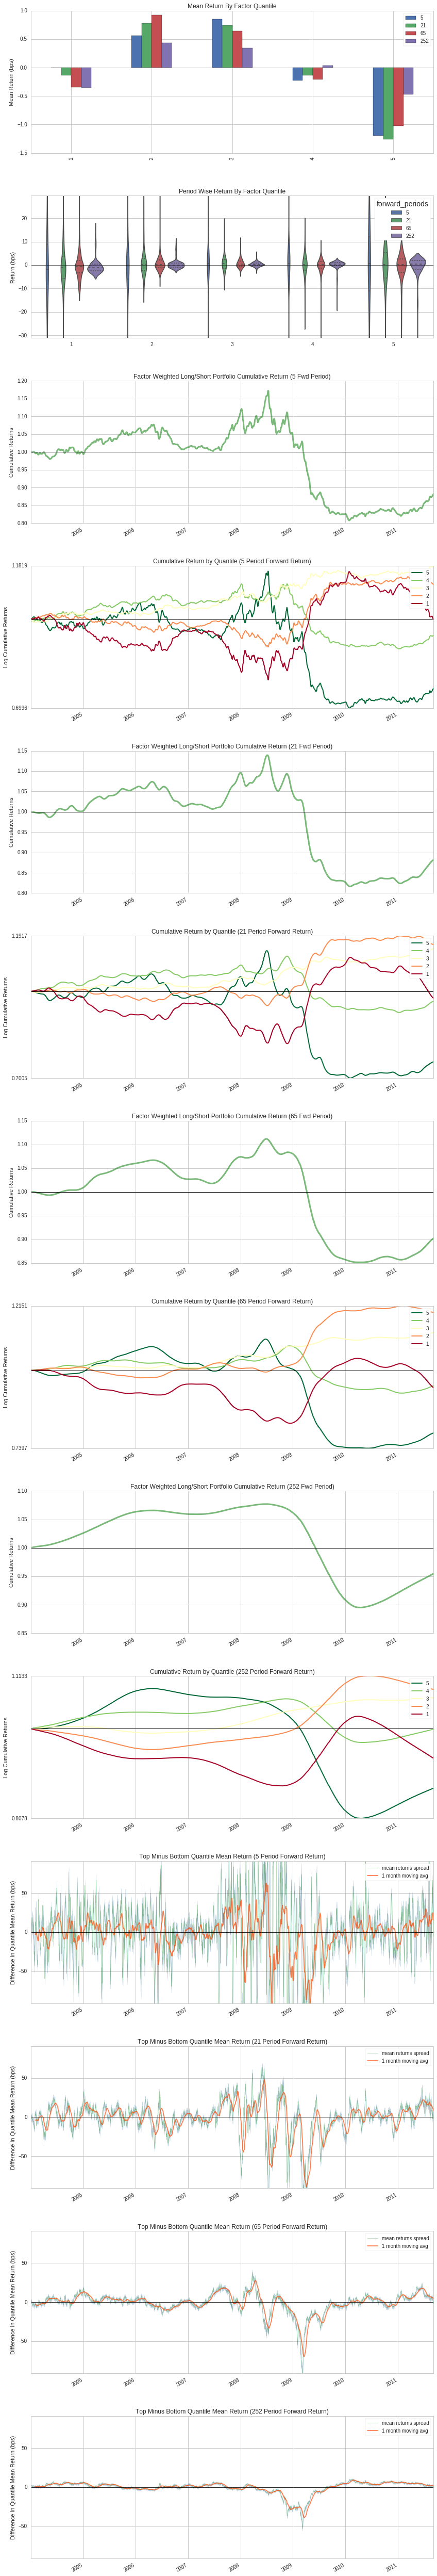

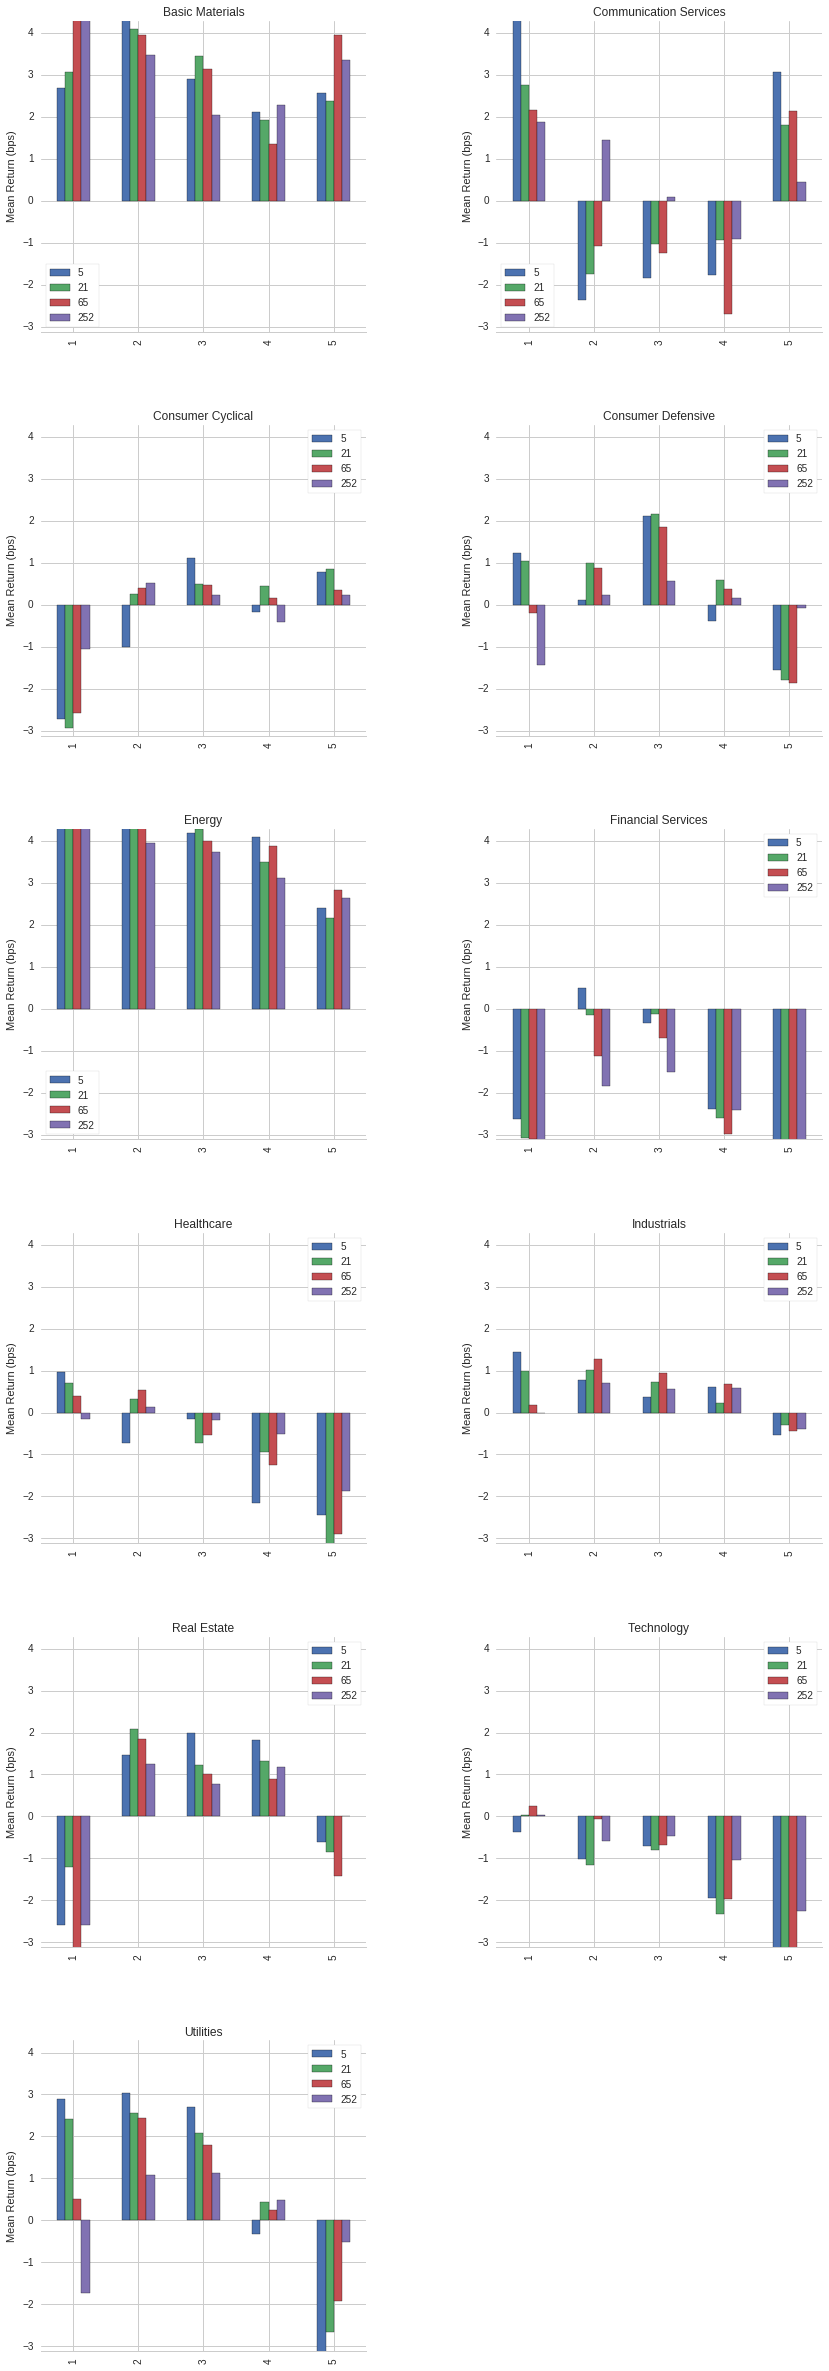

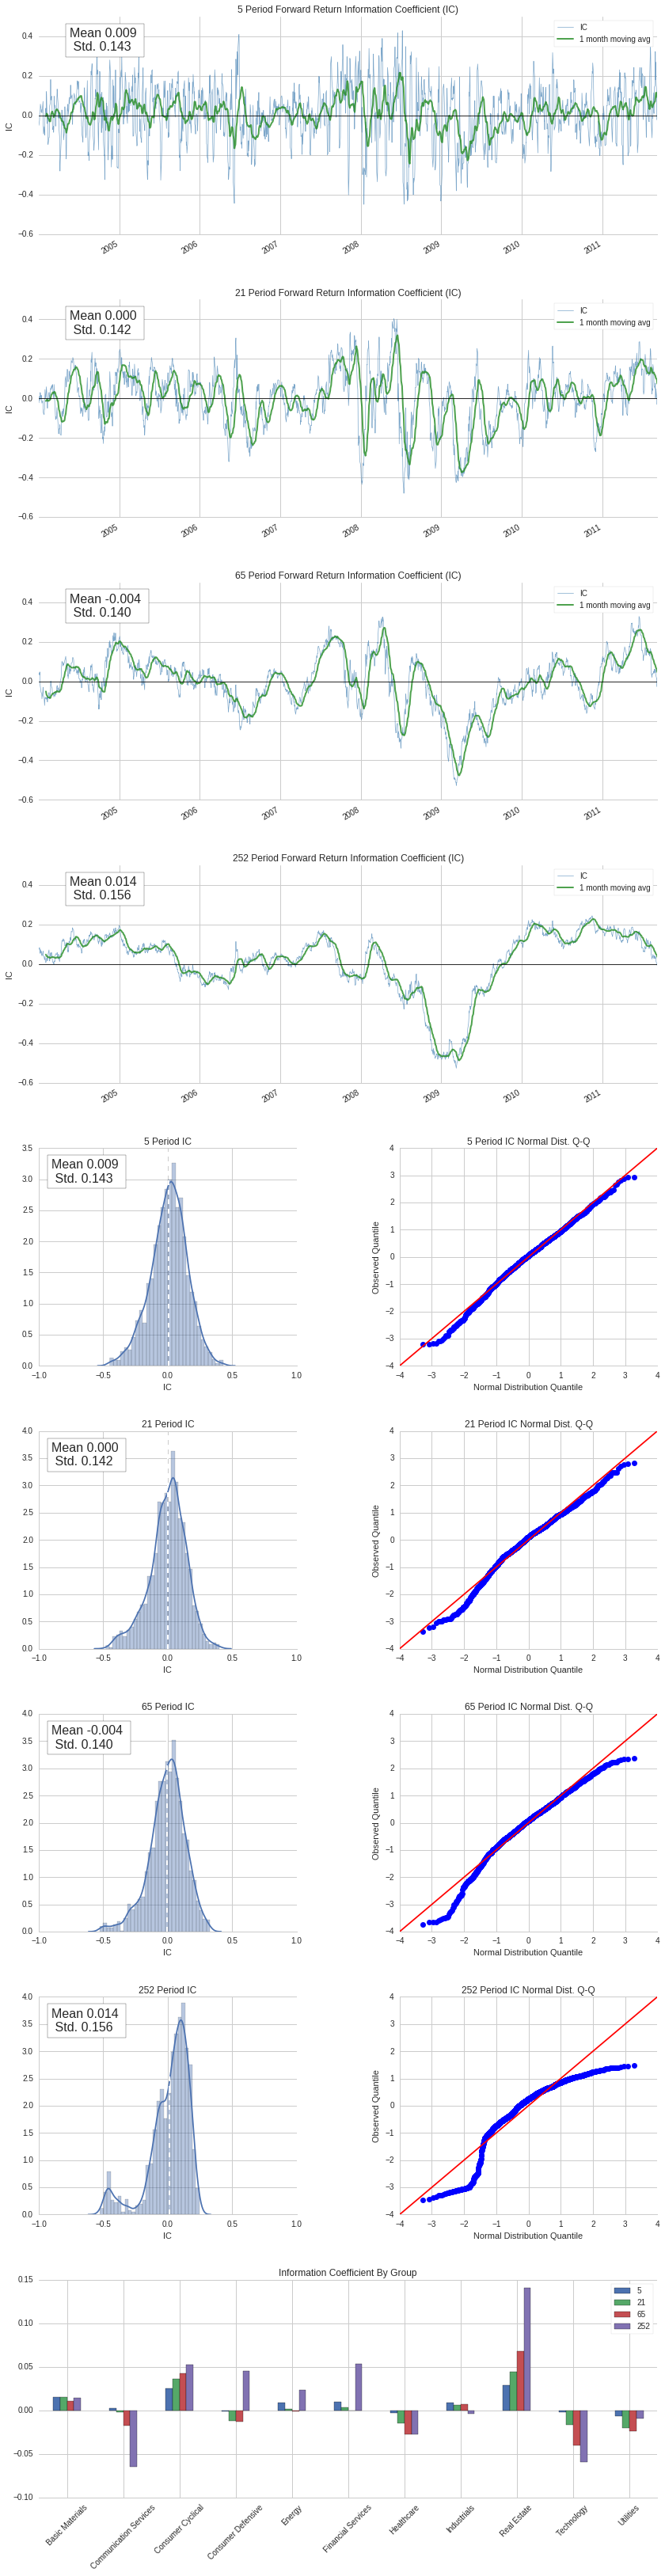

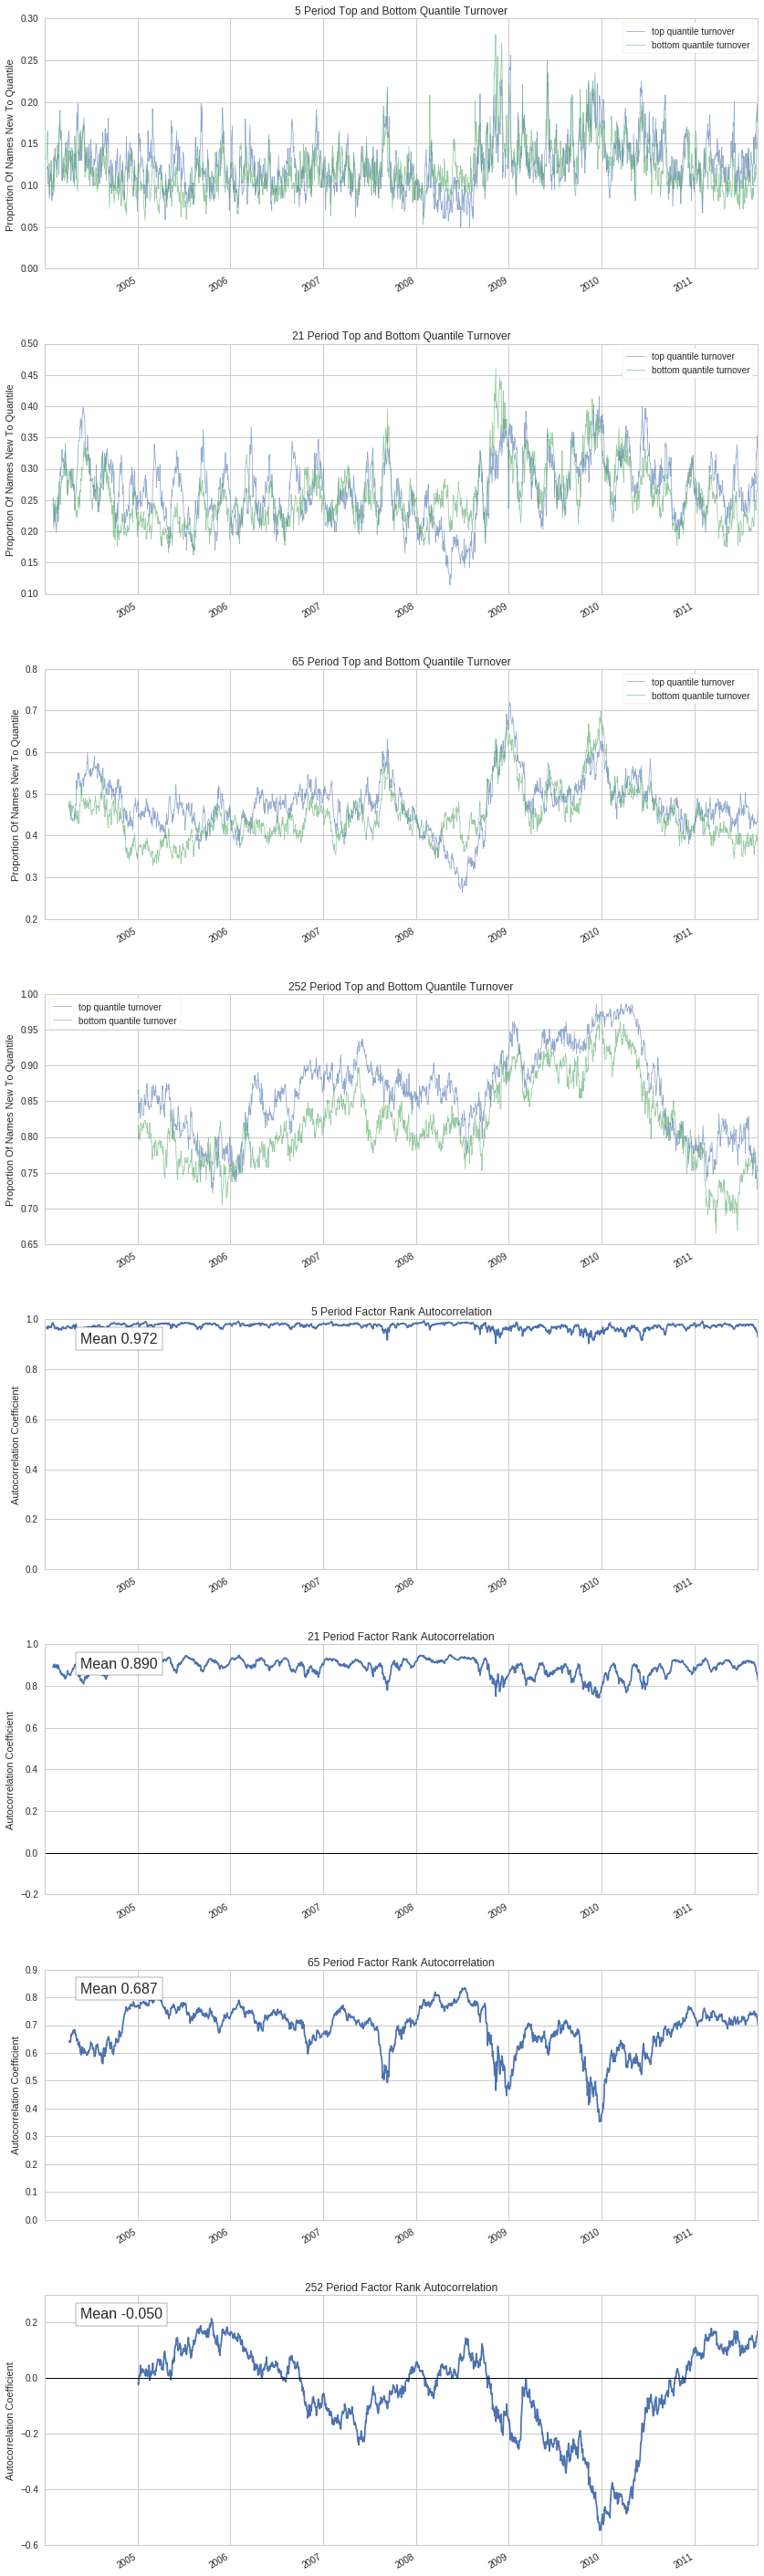

In [30]:
al.tears.create_full_tear_sheet(factor_data_13_1,
                                by_group=True,
                                long_short=True)

# Recent Time Period

In [31]:
start_date = '2012-01-01' 
end_date = '2017-07-01'

# result = run_pipeline(make_pipeline(), start_date, end_date)

# Run Pipeline in chunks
result = run_pipe_in_chunks(make_pipeline(), 
                            start_date, 
                            end_date, 
                            weeks=50, days=0)
  

Running Pipeline for 2012-01-01 00:00:00 to 2012-12-16 00:00:00
Running Pipeline for 2012-12-18 00:00:00 to 2013-12-03 00:00:00
Running Pipeline for 2013-12-04 00:00:00 to 2014-11-19 00:00:00
Running Pipeline for 2014-11-20 00:00:00 to 2015-11-05 00:00:00
Running Pipeline for 2015-11-06 00:00:00 to 2016-10-21 00:00:00
Running Pipeline for 2016-10-22 00:00:00 to 2017-07-01 00:00:00
Pipeline Computations Complete


In [38]:
assets = result.index.levels[1].unique()

# Set the number of additional days for which to fetch pricing data
FORWARD_DAYS = 252

# Fetch pricing data
pricing = get_pricing(assets, start_date, 
                      pd.Timestamp(end_date) + pd.Timedelta(days=FORWARD_DAYS),
                      fields="open_price")  

PERIODS=(5,21,65,252)

In [39]:
factor_data_13_1 = al.utils.get_clean_factor_and_forward_returns(factor=result['Momentum_13_1_rank'],
                                                            prices=pricing,
                                                            groupby=result['Sector_code'],
                                                            by_group=False,
                                                            groupby_labels=MORNINGSTAR_SECTOR_CODES,
                                                            quantiles=5,
                                                            periods=PERIODS)

Quantiles Statistics


min     max         mean        std   count    count %
factor_quantile                                                           
1                   1.0   307.0   146.438705  84.356703  318645  20.028813
2                 284.0   608.0   438.377530  84.501311  317967  19.986197
3                 566.0   904.0   729.989361  84.530593  317928  19.983745
4                 856.0  1195.0  1020.560388  84.229204  317967  19.986197
5                1138.0  1488.0  1311.758782  84.909848  318426  20.015048

Returns Analysis


5       21       65   \
Ann. alpha                                      0.042   0.045    0.045   
beta                                           -0.148  -0.179   -0.239   
Mean Period Wise Return Top Quantile (bps)      0.196   2.348   -7.175   
Mean Period Wise Return Bottom Quantile (bps) -11.140 -45.606 -139.036   
Mean Period Wise Spread (bps)                   2.325   2.342    2.100   

                                                   252  
Ann. alpha                                       0.040  
beta                                            -0.250  
Mean Period Wise Return Top Quantile (bps)     -43.280  
Mean Period Wise Return Bottom Quantile (bps) -262.227  
Mean Period Wise Spread (bps)                    0.946

Information Analysis


5      21     65     252
IC Mean      0.018  0.024  0.026  0.030
IC Std.      0.176  0.164  0.153  0.130
t-stat(IC)   3.381  4.868  5.772  7.741
p-value(IC)  0.001  0.000  0.000  0.000
IC Skew     -0.174 -0.199  0.252  0.249
IC Kurtosis -0.062 -0.236 -0.079 -0.027
Ann. IR      1.590  2.289  2.714  3.639

Turnover Analysis


5     21     65    252
Quantile 1 Mean Turnover   0.102  0.220  0.396  0.774
Quantile 2 Mean Turnover   0.236  0.458  0.659  0.825
Quantile 3 Mean Turnover   0.277  0.514  0.699  0.809
Quantile 4 Mean Turnover   0.248  0.475  0.664  0.798
Quantile 5 Mean Turnover   0.111  0.241  0.445  0.832

5     21     65    252
Mean Factor Rank Autocorrelation  0.978  0.913  0.737  0.065

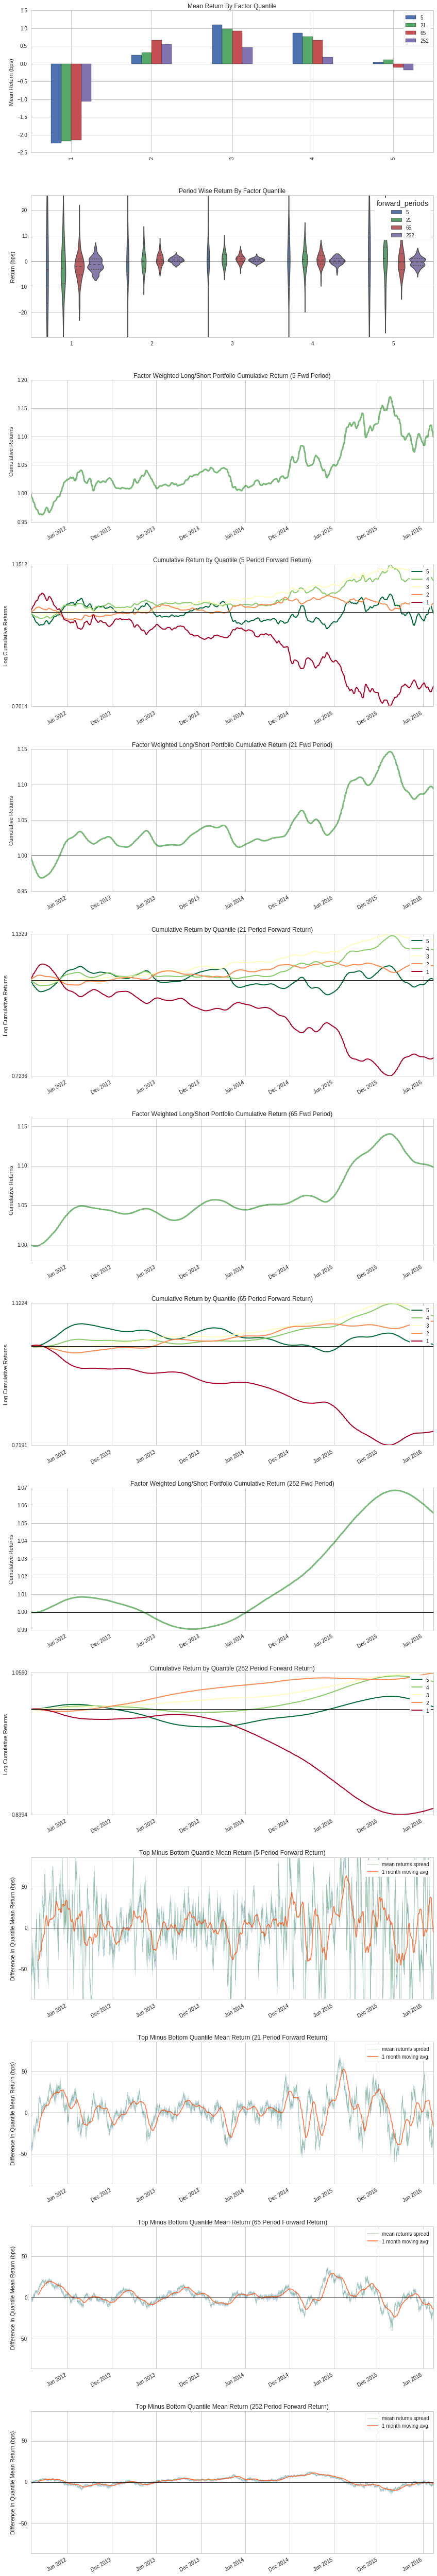

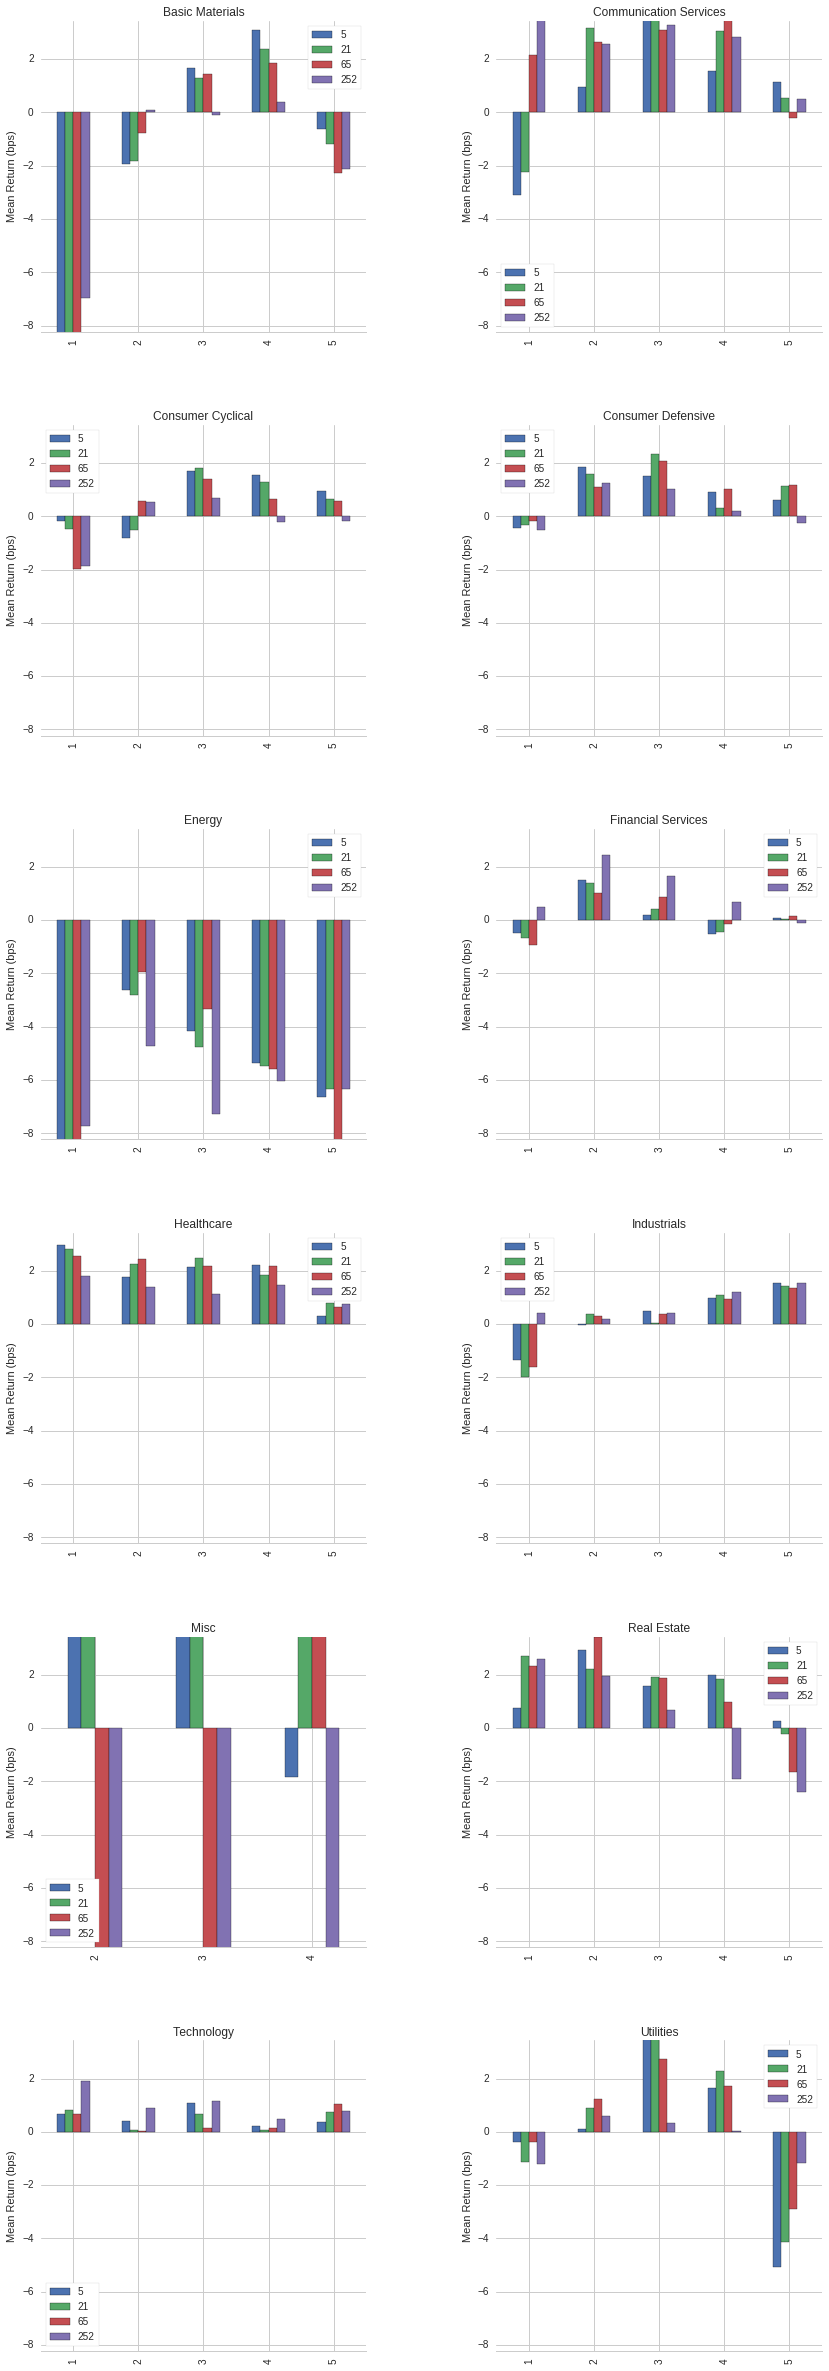

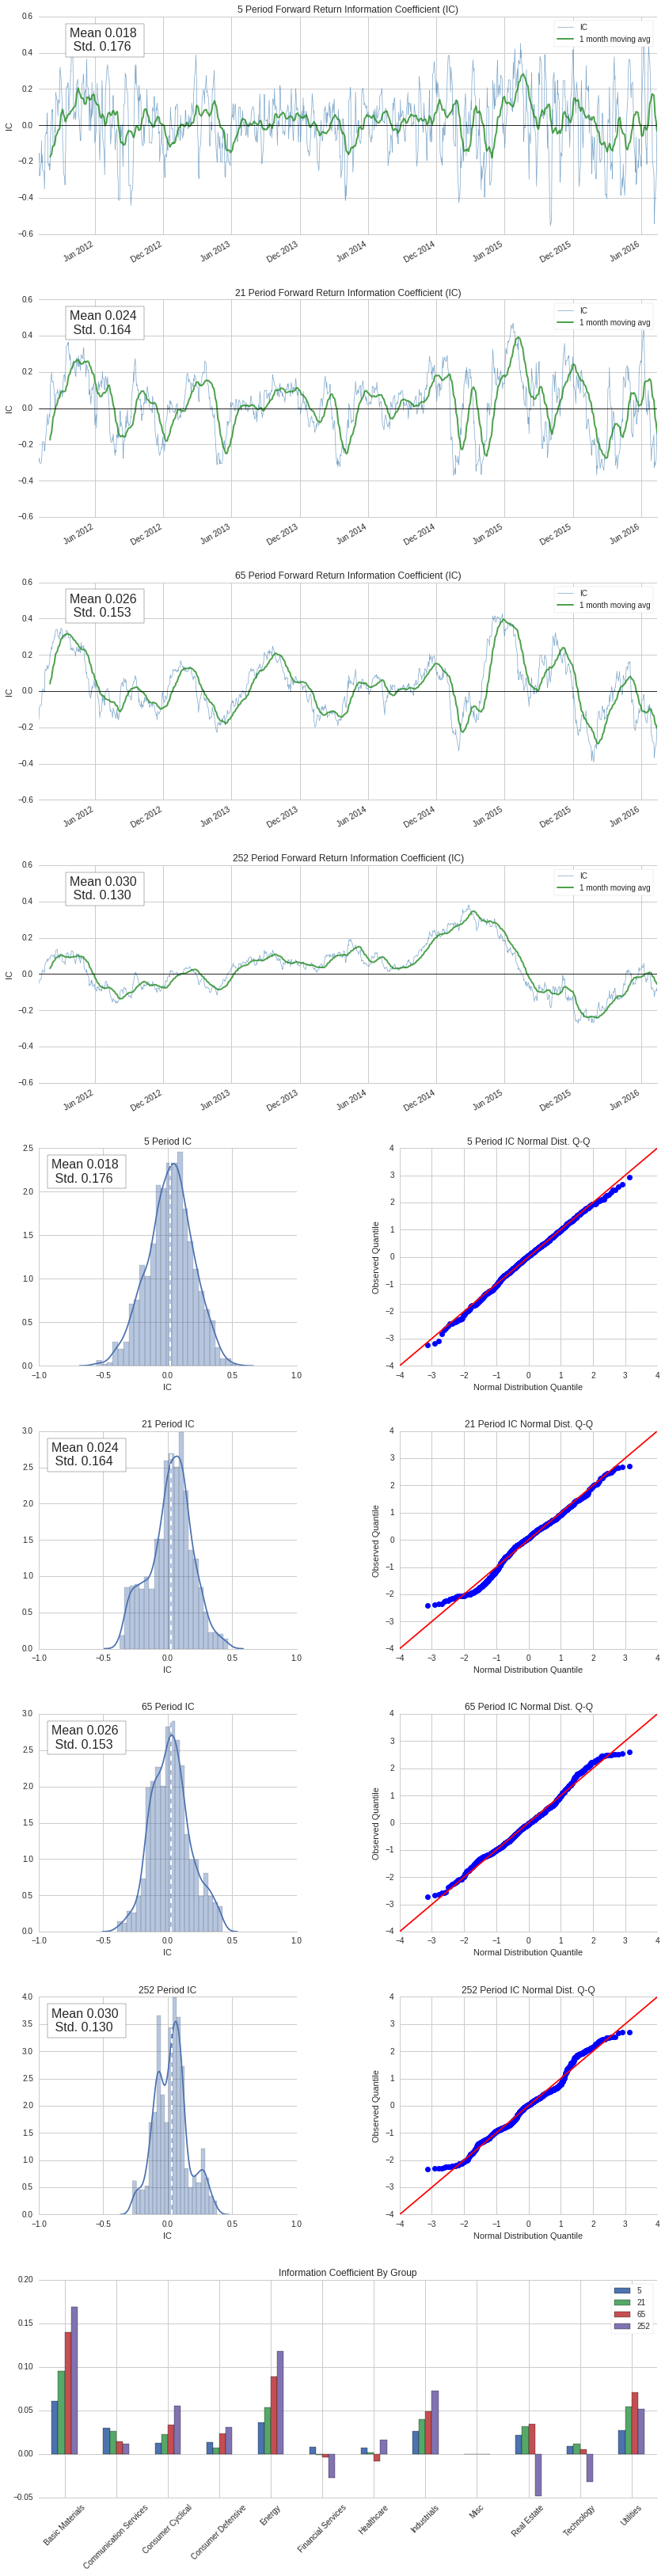

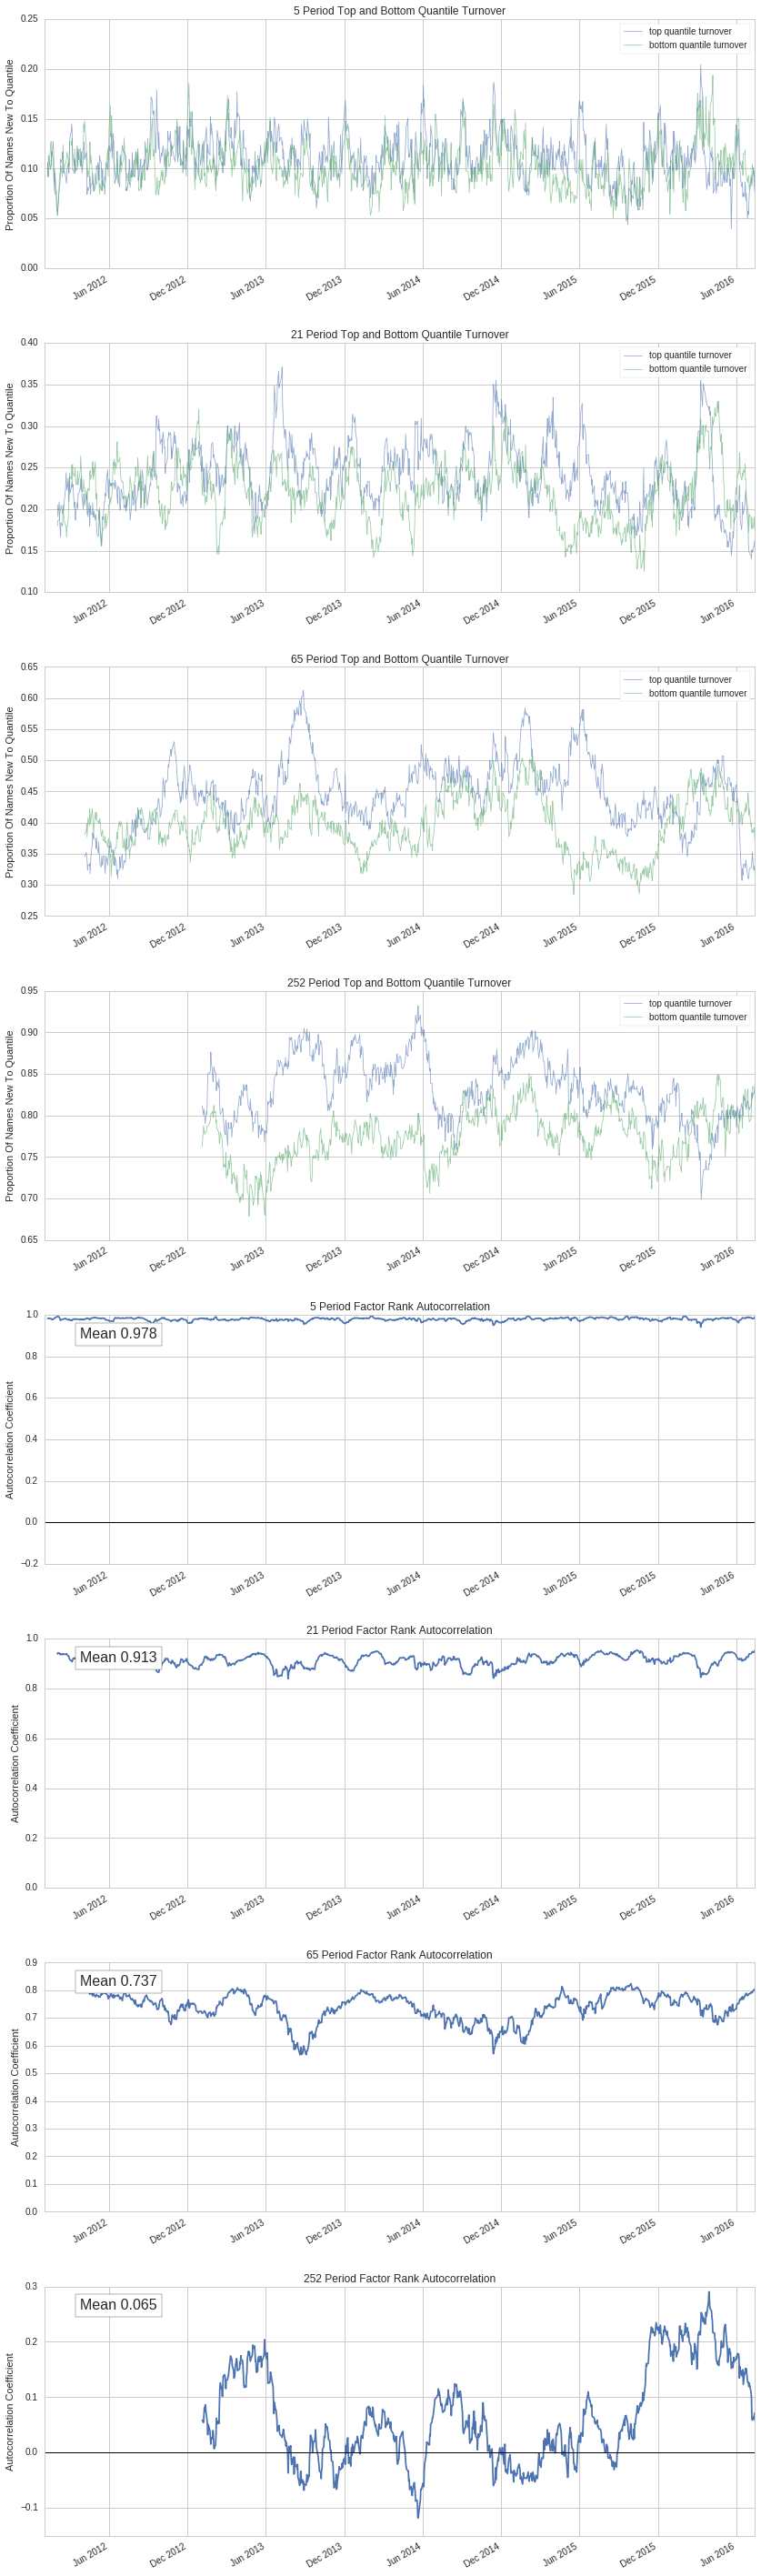

In [41]:
al.tears.create_full_tear_sheet(factor_data_13_1,
                                by_group=True,
                                long_short=True)

# Historical Perspective on Momentum

In [47]:
from pandas_datareader import wb

SandboxViolation: Importing wb from pandas_datareader raised an ImportError. No modules or attributes with a similar name were found.